In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
# import pickle
# import sklearn 
import sys
import pandas as pd
from importlib import reload
import sklearn.metrics

import geopandas as gpd

import warnings

from scipy.stats import spearmanr

## Compare satellite-based HDI ADM2 estimates in Mexico to census-derived estimates

In order to replicate, this analysis, the user will need to create the `data/preds/hdi_preds_at_adm2.p` file which is created in the `hdi_preds_at_adm2.ipynb` notebook. This pickle file also contains the ADM2 shapes.

Alternatively, users can manually merge the tabular ADM2 estimates in `hdi_preds_at_adm2.csv` with the ADM2 geoBoundaries shapefile.

In addition, replication will require the Mexico census ADM2 shapefile, which can be downloaded from https://datacatalog.worldbank.org/search/dataset/0039294

In [2]:
mex_dir = data_dir + "raw/Permanyer_MHDI/"

# Satellite-derived HDI for Mexican municipalities
sat = pd.read_pickle(data_dir + "preds/hdi_preds_at_adm2.p")

sat = sat[sat["shapeGroup"] == "MEX"]

# Census-derived HDI for Mexican municipalities 
census = pd.read_csv(mex_dir+ "mexico_municipality_hdi.csv")

In [3]:
sat.rename(columns = {"adjusted_preds" : "adm2_pred","adm1_mean":"adm1_truth"},inplace=True)

In [4]:
census_shape = gpd.read_file(mex_dir + "muni_2012gw/Muni_2012gw.shp")


# ### Make combined unique id (primary key) for census shapes
census_shape["id"] = census_shape["CVE_ENT"] + census_shape["CVE_MUN"]

In [5]:
### Add leading 0s to survey identifier

In [6]:
def fix_leading_0s(x, correct_length=5):
    assert type(x) is str
    while len(x) < correct_length:
        x = "0" + x
    return x

In [7]:
census["code"] = census["code"].astype(str)
census["code"] = census["code"].apply(fix_leading_0s)

### Inspect data

In [8]:
census_shape.head()

,CVE_ENT,CVE_MUN,NOM_MUN,OID_1,cov_,cov_id,geometry,id
0,01,005,Jesús María,1,1,2,"POLYGON ((-102.33568 22.05067, -102.33348 22.0...",01005
1,01,011,San Francisco de los Romo,2,2,3,"POLYGON ((-102.15272 22.08962, -102.15100 22.0...",01011
2,01,001,Aguascalientes,3,3,4,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",01001
3,01,008,San José de Gracia,4,4,5,"POLYGON ((-102.45611 22.32323, -102.45537 22.3...",01008
4,01,007,Rincón de Romos,5,5,6,"POLYGON ((-102.22684 22.37393, -102.22661 22.3...",01007


In [9]:
census.head()

,code,name,mhdi
0,01001,Aguascalientes,0.800166
1,01002,Asientos,0.699480
2,01003,Calvillo,0.720626
3,01004,Cosío,0.732867
4,01005,Jesús María,0.750694


In [10]:
sat.head()

,shapeName,shapeISO,shapeGroup,shapeType,ADM1_shapeID,ADM0_shapeID,ADMHIERARCHY,geometry,GDL_ADM1,percent_overlap_GDL_ADM1,predicted_dev_from_adm0,adm1_truth,mean_of_pred_adm2_obs,adj_factor,adm2_pred,total_pop,area_sq_km
shapeID,,,,,,,,,,,,,,,,,
MEX-ADM2-3_0_0-B1,Asientos,None,MEX,ADM2,MEX-ADM1-3_0_0-B1,MEX-ADM0-3_0_0-B1,MEX-ADM2-3_0_0-B1|MEX-ADM1-3_0_0-B1|MEX-ADM0-3...,"POLYGON ((-101.99940 22.21948, -101.99955 22.2...",MEXr101,59.83,-0.034347,0.797,-0.007321,0.804321,0.769975,55286,548.953175
MEX-ADM2-3_0_0-B2,San Francisco de los Romo,None,MEX,ADM2,MEX-ADM1-3_0_0-B1,MEX-ADM0-3_0_0-B1,MEX-ADM2-3_0_0-B2|MEX-ADM1-3_0_0-B1|MEX-ADM0-3...,"POLYGON ((-102.19107 22.06615, -102.19091 22.0...",MEXr101,100.00,0.015127,0.797,-0.007321,0.804321,0.819448,42300,139.226606
MEX-ADM2-3_0_0-B3,Rincón de Romos,None,MEX,ADM2,MEX-ADM1-3_0_0-B1,MEX-ADM0-3_0_0-B1,MEX-ADM2-3_0_0-B3|MEX-ADM1-3_0_0-B1|MEX-ADM0-3...,"POLYGON ((-102.18902 22.36240, -102.21198 22.3...",MEXr101,81.70,-0.000460,0.797,-0.007321,0.804321,0.803862,61636,376.199316
MEX-ADM2-3_0_0-B4,San José de Gracia,None,MEX,ADM2,MEX-ADM1-3_0_0-B1,MEX-ADM0-3_0_0-B1,MEX-ADM2-3_0_0-B4|MEX-ADM1-3_0_0-B1|MEX-ADM0-3...,"POLYGON ((-102.46218 22.32281, -102.46325 22.3...",MEXr101,88.67,-0.017141,0.797,-0.007321,0.804321,0.787180,10809,866.545535
MEX-ADM2-3_0_0-B5,Jesús María,None,MEX,ADM2,MEX-ADM1-3_0_0-B1,MEX-ADM0-3_0_0-B1,MEX-ADM2-3_0_0-B5|MEX-ADM1-3_0_0-B1|MEX-ADM0-3...,"POLYGON ((-102.31032 22.03719, -102.31940 22.0...",MEXr101,100.00,0.015477,0.797,-0.007321,0.804321,0.819798,116804,505.043857


#### Spatially join the datasets

In [11]:
def get_adm2_to_census_intersection(adm2, census):
    
    """
    This function takes the two polygons and calculates the overlap, including the % overlap. 
    
    It returns a merged geodataframe object
    
    """
    overlaps_list = []
    percentages_list = []
    
    
    for adm2_geometry in adm2["geometry"]:
        bools = census.intersects(adm2_geometry)
        
        overlaps = list(census["id"].loc[bools])
        
        with warnings.catch_warnings():
            #Ignore warnings about area calculations. We do not need 
            warnings.simplefilter("ignore")
            percentages = list(census.loc[bools].intersection(adm2_geometry).area / adm2_geometry.area)

        overlaps_list.append(overlaps)
        percentages_list.append(percentages)

    adm2_copy = adm2.copy()
    adm2_copy["overlaps"] = overlaps_list
    adm2_copy["percent_overlaps"] = percentages_list
    
    return adm2_copy
    

In [12]:
out = get_adm2_to_census_intersection(sat, census_shape)

<AxesSubplot:>

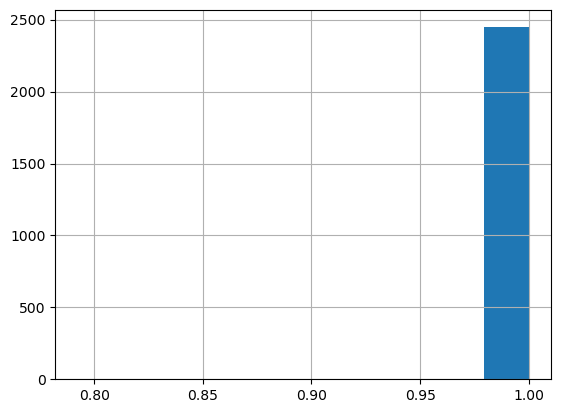

In [13]:
out["percent_overlaps"].apply(max).hist()

In [14]:
## The smallest intersection is 80%. This is great.

out["percent_overlaps"].apply(max).min()

0.7924573250561853

In [15]:
arg_maxes = out["percent_overlaps"].apply(np.argmax)
final_overlap_percentages = [out["percent_overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]
final_overlap_code = [out["overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]

In [16]:
sat["census_code"] = final_overlap_code 
sat["overlap_perc"] = final_overlap_percentages

### Let's make sure the names appear the same as well

In [17]:
sat_names = sat["shapeName"]

In [18]:
census_names = census_shape.set_index("id").loc[sat["census_code"]]["NOM_MUN"]

In [19]:
#sat_names[~(sat_names.to_numpy() == census_names.to_numpy())]

In [20]:
#census_names[~(sat_names.to_numpy() == census_names.to_numpy())]

These match very well. The only concerning is Benito Juárez and Puerto Morelos. They overlap 97% however, which indicats that the name may be entered incorrectly in the ADM2 data. Since they are geographically the same, we will not drop.

## Now we can compare performance

In [21]:
data = sat[["shapeName","shapeGroup","ADM1_shapeID","census_code","total_pop"]].reset_index()

In [22]:
data = data.merge(census,"left", left_on="census_code", right_on="code")

In [23]:
data = data.merge(sat[["adm2_pred","GDL_ADM1","adm1_truth"]],
                  "left", left_on="shapeID", right_index=True)

In [24]:
null_count = data["adm2_pred"].isnull().sum() + data["mhdi"].isnull().sum()

print("We dont have preds for", null_count, "ADM2 observations. These will be dropped")

print("This is", round(null_count/len(data) * 100,2), "% of the data.")

We dont have preds for 1 ADM2 observations. These will be dropped
This is 0.04 % of the data.


In [25]:
data.dropna(subset = ["adm2_pred", "mhdi"], inplace=True)

In [26]:
data["within_adm0_true"] = data["mhdi"] - data["mhdi"].mean()
data["within_adm0_pred"] = data["adm2_pred"] - data["adm2_pred"].mean()

## Now we need to look within ADM1

In [27]:
adm1_pred_means = data.groupby("GDL_ADM1")["adm2_pred"].mean().rename("adm1_pred_mean")
adm1_true_means = data.groupby("GDL_ADM1")["mhdi"].mean().rename("adm1_true_mean")

In [28]:
data = data.merge(adm1_pred_means, "left", left_on="GDL_ADM1", right_index=True)
data = data.merge(adm1_true_means, "left", left_on="GDL_ADM1", right_index=True)

In [29]:
data["within_adm1_pred"] = data["adm2_pred"] - data["adm1_pred_mean"]
data["within_adm1_true"] = data["mhdi"] - data["adm1_true_mean"]

In [30]:
data.to_pickle(data_dir + "preds/mexico_pred_and_observed.p")

### Now we make a performance table

In [31]:
all_model_preds = pd.read_pickle(data_dir + "preds/hdi_preds_from_all_models_at_adm2.p").loc[data["shapeID"]]

In [32]:
all_model_preds = all_model_preds.merge(data.set_index("shapeID")[["GDL_ADM1","mhdi"]], "left", left_index=True, right_index=True)

In [33]:
all_model_preds.std()

/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


rcf_and_nl_cc_preds        0.063446
rcf_cc_preds               0.088614
nl_cc_preds                0.121603
adm0_rcf_and_nl_preds      0.107296
adm0_rcf_preds             0.168883
adm0_nl_preds              0.175912
within_rcf_and_nl_preds    0.047109
within_rcf_preds           0.050891
within_nl_preds            0.047461
mhdi                       0.097229
dtype: float64

In [34]:
def get_perf_metrics(col, df, truth_col="mhdi"):
    perf = {}
    
    within_adm0_true = df[truth_col] - df[truth_col].mean()
    within_adm0_pred = df[col] - df[col].mean()
    
    perf["within_adm0_pearson"] = np.corrcoef( within_adm0_true,within_adm0_pred )[0,1] **2
    perf["within_adm0_spearman"] = spearmanr(within_adm0_true,within_adm0_pred ).correlation
    perf["within_adm0_r2"]  = sklearn.metrics.r2_score(within_adm0_true,within_adm0_pred )
    
    grouped = all_model_preds.groupby("GDL_ADM1")[[col, truth_col]].mean().rename(columns = {col:"adm1_pred_grouped_mean", 
                                                                              truth_col:"adm1_truth_grouped_mean"})
    df = df.merge(grouped, "left", left_on="GDL_ADM1", right_index=True )
    
    within_adm1_true = df[truth_col] - df["adm1_truth_grouped_mean"]
    within_adm1_pred = df[col] - df["adm1_pred_grouped_mean"]
    
    perf["within_adm1_pearson"] = np.corrcoef( within_adm1_true,within_adm1_pred )[0,1] **2
    perf["within_adm1_spearman"] = spearmanr(within_adm1_true,within_adm1_pred ).correlation
    perf["within_adm1_r2"]  = sklearn.metrics.r2_score(within_adm1_true,within_adm1_pred )
    
    return perf
    
    
    
    


In [35]:
perf_dict = {}
for col in all_model_preds.columns[:-2]:
    perf_dict[col] = get_perf_metrics(col, all_model_preds)

    

### Create output table

In [36]:
rename_dict = { "within_adm0_pearson": "$\rho^{2}$", "within_adm0_spearman":"Spearman r", "within_adm0_r2":"$R^{2}$",
               "within_adm1_pearson": "$\rho^{2}$", "within_adm1_spearman":"Spearman r", "within_adm1_r2":"$R^{2}$"}

In [37]:
table = pd.DataFrame(perf_dict).T.round(2)
table[table <= 0] = "$< 0$"
table = table.rename(columns = rename_dict)

In [38]:
table.loc[0:3,"Mexico HDI"] = "\textbf{Province level}"
table.loc[3:6,"Mexico HDI"] = "\textbf{Country level}"
table.loc[6:10,"Mexico HDI"] = "\textbf{Within-country}"

table.loc[0:3,""] = ["\textbf{MOSAIKS+NL}","\textbf{MOSAIKS}","\textbf{NL}"]
table.loc[3:6,""] = ["\textbf{MOSAIKS+NL}","\textbf{MOSAIKS}","\textbf{NL}"]
table.loc[6:9,""] = ["\textbf{MOSAIKS+NL}","\textbf{MOSAIKS}","\textbf{NL}"]

table.loc[9] = "\textbf{Predicted at municipality level in Mexico" +  " (n={:,})".format(len(data))

table.loc[10] = "\emph{Within-country performance}"
table.iloc[10,3:6] = "\emph{Within-province performance}"

table.drop(columns="Spearman r", inplace=True)

table.loc[11] = ("(" + pd.Series(np.arange(1,table.shape[1]+1)).astype(str) +")").to_numpy()

table = table.T.reset_index().set_index([9,10,"index",11])

tab = table.T

tab.columns.names = ([None, None, None,None])

table = tab.set_index([tab.columns[-2],tab.columns[-1]])

table.index.names =["\emph{ \textbf{" + "HDI" + " trained at:}}", "\emph{ \textbf{Features}}"]
table = table.iloc[[6,7,8,0,1,2,3,4,5]]
table

/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


\textbf{Predicted at municipality level in Mexico (n=2,457)  \
                                                                                     \emph{Within-country performance}   
                                                                                                            $\rho^{2}$   
                                                                                                                   (1)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                                               
\textbf{Within-country}          \textbf{MOSAIKS+NL}                                                      0.5            
                                 \textbf{MOSAIKS}                                                        0.41            
                                 \textbf{NL}                                                             0.58            
\textbf{Province level}          \textbf{MOSAIKS+NL}                                                     0.31            
                                 \textbf{MOSAIKS}                                                         0.3            
                                 \textbf{NL}                                                             0.29            
\textbf{Country level}           \textbf{MOSAIKS+NL}                                                     0.16            
                                 \textbf{MOSAIKS}                                                        0.16            
                                 \textbf{NL}                                                             0.34            

                                                                    \
                                                                     
                                                           $R^{2}$   
                                                               (2)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country}          \textbf{MOSAIKS+NL}          0.45   
                                 \textbf{MOSAIKS}              0.4   
                                 \textbf{NL}                   0.5   
\textbf{Province level}          \textbf{MOSAIKS+NL}          0.31   
                                 \textbf{MOSAIKS}             0.16   
                                 \textbf{NL}                 $< 0$   
\textbf{Country level}           \textbf{MOSAIKS+NL}         $< 0$   
                                 \textbf{MOSAIKS}            $< 0$   
                                 \textbf{NL}                 $< 0$   

                                                                                               \
                                                           \emph{Within-province performance}   
                                                                                   $\rho^{2}$   
                                                                                          (3)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                      
\textbf{Within-country}          \textbf{MOSAIKS+NL}                                     0.31   
                                 \textbf{MOSAIKS}                                        0.21   
                                 \textbf{NL}                                             0.44   
\textbf{Province level}          \textbf{MOSAIKS+NL}                                     0.26   
                                 \textbf{MOSAIKS}                                        0.22   
                                 \textbf{NL}                                             0.25   
\textbf{Country level}           \textbf{MOSAIKS+NL}                                     0.14   
                                 \textbf{MOSAIKS}                                        0.12   
                                 \textbf{NL}                                              0.3   

          

In [39]:
table.insert(0,"\phantom{TT}","")
table.insert(0,"\phantom{TT.}","")

In [40]:
print(table.to_latex(bold_rows=False,column_format="ll||cc|cc|cc",
          escape=False, multicolumn_format="c"))

\begin{tabular}{ll||cc|cc|cc}
\toprule
                       &             & \phantom{TT.} & \phantom{TT} & \multicolumn{4}{c}{\textbf{Predicted at municipality level in Mexico (n=2,457)} \\
                       &             & \multicolumn{2}{c}{\emph{Within-country performance}} & \multicolumn{2}{c}{\emph{Within-province performance}} \\
                       &             &                                                  $\rho^{2}$ & $R^{2}$ &                         $\rho^{2}$ & $R^{2}$ \\
                       &             &                                                         (1) &     (2) &                                (3) &     (4) \\
\emph{ \textbf{HDI trained at:}} & \emph{ \textbf{Features}} &               &              &                                                             &         &                                    &         \\
\midrule
\textbf{Within-country} & \textbf{MOSAIKS+NL} &               &              &                                    